# ICA on Peak Patch Fields

In [6]:
from pathlib import Path # For path manipulations and module loading

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

"""
Independent Component Analysis

sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
cube for kurtosis and logcosh for negentropy approximation.
"""
from sklearn.decomposition import FastICA

%load_ext autoreload
%autoreload 2
import importlib as il

import sim_params
sim_params = il.reload(sim_params)
import init_fields
init_fields = il.reload(init_fields)
import slicer_fields
from slicer_fields import Slicer1D
slicer_fields = il.reload(slicer_fields)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# d_filename='Fvec_fNL_17Mpc_n1024_nb64_nt1'
# dg_filename='Fvec_17Mpc_n1024_nb64_nt1'
# z_filename='zetang_17Mpc_n1024_nb64_nt1'
# zg_filename='zetag_17Mpc_n1024_nb64_nt1'
# filenames=[d_filename,dg_filename,z_filename, zg_filename]

In [8]:
path_realization = 'peak-patch-runs/n1024bigR/z2/fnl1e6/'
seed = 10

slicer = Slicer1D(seed, path_realization)

Side length (Mpc/h):  17.92 
Side length (array units):  1024 
Buffer thickness (array units):  64 
Side length after trimming buffers:  896

Processing Delta fields/components...


Processing Zeta fields/components...


Checking random entries from each of the fields...


Delta Gauss-comp (199, 861, 753):       10.007865
Delta nonG-comp (199, 861, 753):         19839.383
Delta total (199, 861, 753):             19849.39

Zeta Gauss-comp (199, 861, 753):        5.835529e-11
Zeta nonG-comp (199, 861, 753):          1.6085785e-11
Zeta total (199, 861, 753):              7.444108e-11


In [9]:
factor = int(1e8)

fields = slicer.slice_1d()
d_1d, dg_1d, dng_1d, z_1d, zg_1d, zng_1d = fields


In [12]:
slicer.set_seed(15)
fields = slicer.slice_1d()

d_1d, dg_1d, dng_1d, z_1d, zg_1d, zng_1d = fields

### Plot 1D field-strips

#### Zeta fields

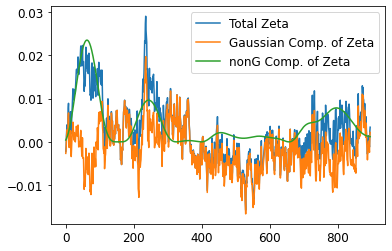

In [16]:
new_seed = 30
slicer.set_seed(new_seed)

fields = slicer.slice_1d()

d_1d, dg_1d, dng_1d, z_1d, zg_1d, zng_1d = fields

z_1d = factor * z_1d
zg_1d = factor * zg_1d
zng_1d = factor * zng_1d

plt.plot(z_1d, label='Total Zeta')
plt.plot(zg_1d, label='Gaussian Comp. of Zeta')
plt.plot(zng_1d, label='nonG Comp. of Zeta')

# plt.ylim([-1, 1])
plt.legend()

## <u>Apply ICA to 1D strips from the 3D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

In [17]:
"""
source_noise    :   grf generated using gaussianfield [in Notebook Setup above]
source_nonG     :   returns n columns corresponding to n gaussian peaks that are shifted by xPeak/xc relative to 0 (and scaled by the size of the field)
source_comps    :   array of source component arrays
num_comps       :   num of different source signals/components, i.e. GRF & no. of peaks
num_samples     :   num of observations (has to be >= num_comps)
mix_matrix      :   mixing matrix generated randomly with entries over [0.5, 1)
mix_signal_pre  :   resulting mixed/observed signals (not prewhitened)
"""

source_noise = zg_1d # Gaussian random noise
source_nonG = zng_1d

source_comps = np.vstack([source_noise, source_nonG]) 
num_comps = source_comps.shape[0]
num_samples = num_comps

mix_matrix = (1+np.random.random((num_samples, num_comps)))/2.0 
print(mix_matrix.shape)
mix_signal_pre = np.dot(mix_matrix, source_comps) # mixed signals
print(mix_signal_pre.shape)

(2, 2)
(2, 896)


### Sklearn--Fully determined FastICA separation

#### Apply Sklearn's $\texttt{FastICA}$

In [76]:
# initialize FastICA with given params
# Logcosh is negentropy.

max_iter = int(9e2)
tol = 1e-8

transformer = FastICA(n_components=num_comps, algorithm='parallel', whiten='unit-variance', max_iter=max_iter, 
        tol=tol, fun='logcosh')

# run FastICA on observed (mixed) signals
sources = transformer.fit_transform(mix_signal_pre.T) # run FastICA on observed signals




0.02349908323484584
0.14421525230656634
0.02349908323484584


In [82]:
source_max  = np.abs(source_comps).max()
ica_max     = np.abs(sources).max()
print(source_max)
print(ica_max)
sl          = sources * ( source_max / ica_max )
sl_max     = np.abs(sl).max()
print(sl_max)

0.02349908323484584
0.14421525230656634
0.02349908323484584


In [83]:
sl = -sl

In [84]:
sl[:,[1,0]] = sl[:, [0,1]]

#### Plot the following:
#### (1) Observed signals (random mixtures of source components),
#### (2) Source components,
#### (3) ICA separated signals.

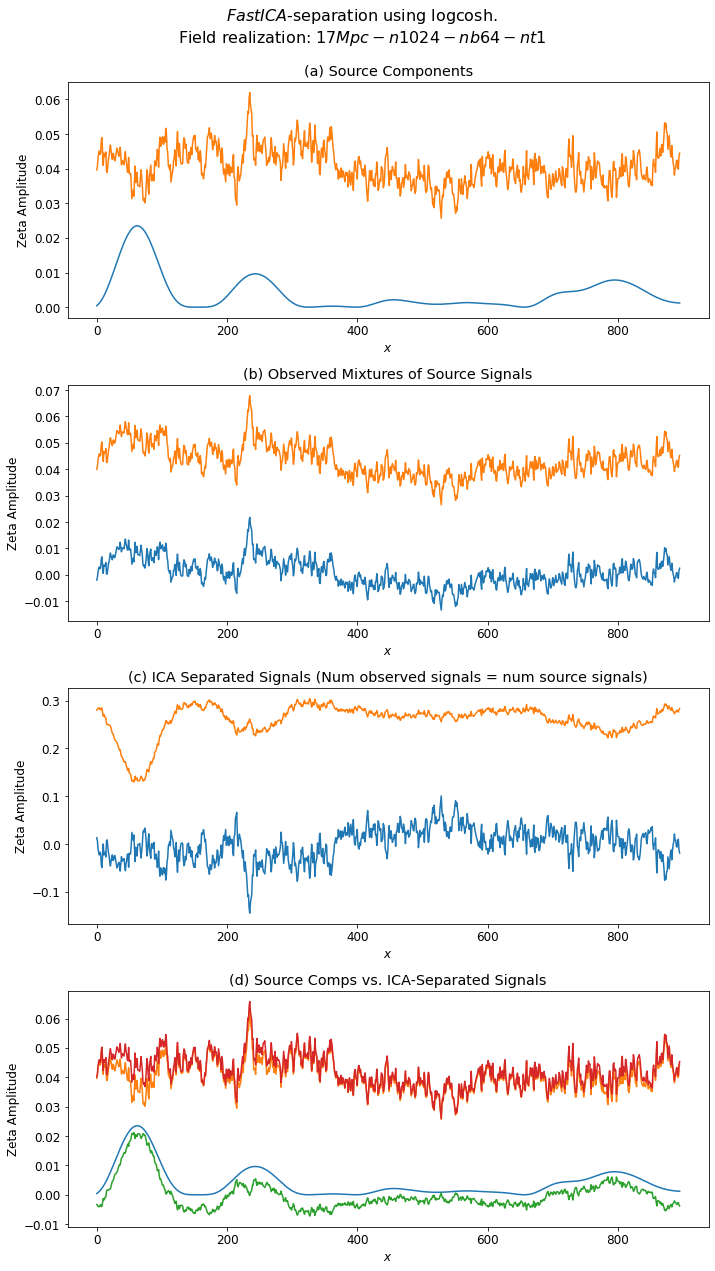

In [85]:
fig, ax = plt.subplots(4,1,figsize=(10,18))

scomps = np.flip(source_comps, axis=0)
offset = source_max*1.8
offset_ica = ica_max*1.8

# Plotting source components
ax[0].set_title("(a) Source Components")
for i in range(scomps.T.shape[-1]):
    ax[0].plot(scomps.T[:,i] + offset*i)
ax[0].set(xlabel=r'$x$', ylabel="Zeta Amplitude")
# ax[0].legend()


# Plotting observed signals (mixtures of source signals)
ax[1].set_title("(b) Observed Mixtures of Source Signals")
for i in range(mix_signal_pre.T.shape[-1]):
    ax[1].plot(mix_signal_pre.T[:,i] + offset*i)
ax[1].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting signals separated by ICA
ax[2].set_title("(c) ICA Separated Signals (Num observed signals = num source signals)")
for i in range(sources.shape[-1]):
    ax[2].plot(sources[:,i] + offset_ica*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[2].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting comparison of source comps and ICA-separated signals
ax[3].set_title("(d) Source Comps vs. ICA-Separated Signals")
for i in range(scomps.T.shape[-1]):
    ax[3].plot(scomps.T[:,i] + offset*i)
for i in range(sl.shape[-1]):
    ax[3].plot(sl[:,i] + offset*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[3].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


fig.suptitle('$\it{FastICA}$-separation using logcosh.\nField realization: $\it{17Mpc-n1024-nb64-nt1}$\n', fontsize=16)
fig.tight_layout()

### [WIP] Rank-order the extracted signals (by a nonG measure)
e.g. using kurtosis

In [ ]:
# # Rank-order by a nonGaussianity measure (kurtosis for simplicity)
# nt = 100; a = np.empty((nt,s.shape[0],s.shape[1])) 
# for i in range(nt):
#     a[i] = ica.extract_peaks_nn(num_samples=num_samples, num_components=num_comps, noise=noise, aPeak=aPeak, xPeak=xPeak, wPeak=wPeak, ns=size_field)[-1]
# kur = ica.kurtosis(a)

# print(kur.shape)
# fig, a = plt.subplots()
# fig.set_size_inches(15, 15)
# for i in range(kur.shape[-1]):
#     a.plot(kur[:,i]+25.*i)